# Cifar10 classification problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pandas import DataFrame

import preprocessing as pp
import cifar10_models as cfm

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
from keras import layers
from keras import models
from keras.utils import to_categorical

# Get to know the data

In [74]:
#10 classes of data
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck']
classes = dict(zip(range(10), classes))


In [102]:
# import Cifar10 data set
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
data = train_images, test_images, train_labels, test_labels

In [6]:
#data shape and type
pp.some_data_attributes(data)

,shape,dtype
train_images,"(50000, 32, 32, 3)",uint8
test_images,"(10000, 32, 32, 3)",uint8
train_labels,"(50000, 1)",uint8
test_labels,"(10000, 1)",int64


In [103]:
# reshape and change types data
train_labels = train_labels.reshape(50000)
test_labels = test_labels.reshape(10000)
train_imgs, test_imgs, train_labs, test_labs = pp.pre_process(data)

onehot train_labels 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

 train_imgs shape (50000, 32, 32, 3)


In [104]:
# data has range from 0-255 for each channels
# rescale data to have values from [0-1]
train_imgs = pp.rescale_images(train_imgs)
test_imgs = pp.rescale_images(test_imgs)
print('max pixel value: %.1f'%np.max(train_imgs))

max pixel value: 1.0


In [54]:
# quick check for a skew distribution of labels
# each class for all train and test set has the same # of examples

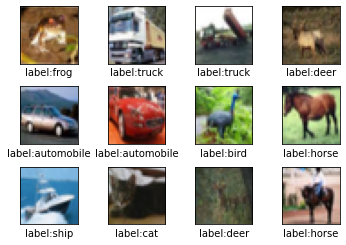

In [73]:
### draw 10 images
images = train_images[:12]
labels = [classes[train_labels[i]] for i in range(12)]
pp.visualize_10_images(images=images, labels= labels)

# experience with models 

In [154]:
import importlib
importlib.reload(pp)
importlib.reload(cfm)

<module 'cifar10_models' from '/home/nguyenmt/Desktop/keras/cifar10_models.py'>

In [96]:
# models1 : this is to see how simple model learn cifar10.
# description of this model is in cifar10_models file

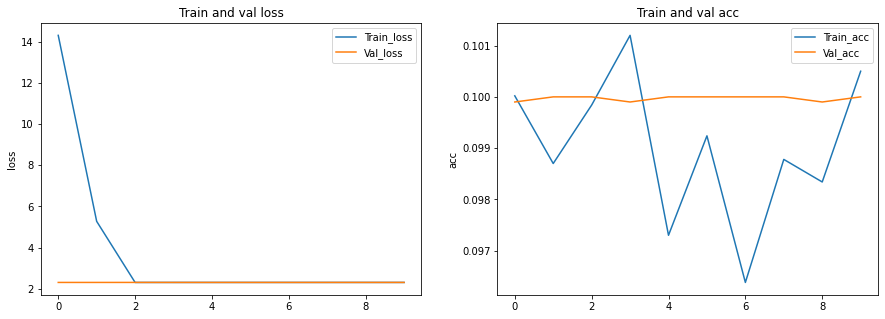

In [98]:
# i only use test set to visualize loss and accuracy without any effect on training
cfm.compile_model(model= cfm.model1, lr= 0.01)
history1 = cfm.train_model(model= cfm.model1, 
                          train_data= [train_imgs, train_labs],
                          validation_data= [test_imgs, test_labs], 
                          verbose= 0)
pp.train_val_result(_history = history1)

In [143]:
cfm.compile_model(model= cfm.model3, lr= 0.00001)
history3 = cfm.model3.fit(x = train_imgs[:20000], y = train_labs[:20000],
                         epochs= 1, batch_size= 256, validation_data= [test_images, test_labs])


AttributeError: 'function' object has no attribute 'compile'

In [133]:
lrs = np.linspace(start= 5e-5, stop = 1e-4, num= 5)
print(lrs)
for lr in lrs:
    model3_1 = cfm.model3_1()
    cfm.compile_model(model= model3_1, lr= lr)
    history3_1 = model3_1.fit(x = train_imgs[:10000], y = train_labs[:10000],
                             epochs= 1, batch_size= 256)

[5.00e-05 6.25e-05 7.50e-05 8.75e-05 1.00e-04]
Epoch 1/1
10000/10000 [==============================] - 91s 9ms/step - loss: 1.8977 - accuracy: 0.3268
Epoch 1/1
10000/10000 [==============================] - 91s 9ms/step - loss: 1.8587 - accuracy: 0.3457
Epoch 1/1
10000/10000 [==============================] - 91s 9ms/step - loss: 1.8632 - accuracy: 0.3410
Epoch 1/1
10000/10000 [==============================] - 92s 9ms/step - loss: 1.8347 - accuracy: 0.3553
Epoch 1/1
10000/10000 [==============================] - 90s 9ms/step - loss: 1.9002 - accuracy: 0.3555


In [142]:
lrs = np.linspace(start= 3e-5, stop = 1e-4, num= 5)
print(lrs)
for lr in lrs:
    model3_2 = cfm.model3_2()
    cfm.compile_model(model= model3_2, lr= lr)
    history3_2 = model3_2.fit(x = train_imgs[:10000], y = train_labs[:10000],
                             epochs= 1, batch_size= 256)
    print('learning rate: %f'%(lr))

[3.00e-05 4.75e-05 6.50e-05 8.25e-05 1.00e-04]
Epoch 1/1
10000/10000 [==============================] - 42s 4ms/step - loss: 2.4626 - accuracy: 0.1734
learning rate: 0.000030
Epoch 1/1
10000/10000 [==============================] - 39s 4ms/step - loss: 2.2709 - accuracy: 0.2210
learning rate: 0.000048
Epoch 1/1
10000/10000 [==============================] - 40s 4ms/step - loss: 2.2764 - accuracy: 0.2222
learning rate: 0.000065
Epoch 1/1
10000/10000 [==============================] - 40s 4ms/step - loss: 2.2491 - accuracy: 0.2324
learning rate: 0.000082
Epoch 1/1
10000/10000 [==============================] - 40s 4ms/step - loss: 2.1647 - accuracy: 0.2528
learning rate: 0.000100


In [157]:
# i decided to choose model 3_2 and apply regularization droput and pick lr of 6*e-5
lr = 6*1e-5
model3_2 = cfm.model3_2()
cfm.compile_model(model= model3_2, lr= lr)
history3_2 = model3_2.fit(x = train_imgs, y = train_labs, validation_data = [test_imgs, test_labs],
                         epochs= 1, batch_size= 256)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 165s 3ms/step - loss: 2.2213 - accuracy: 0.2279 - val_loss: 2.5084 - val_accuracy: 0.1004
